<a href="https://colab.research.google.com/github/bieri2/ATMS597_Project5_GroupB/blob/master/ATMS597_Project5_SVM_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ATMS-597 Project-5 Group-B 
<b>Group members:</b> Carolina Bieri, Divyansh Chug, Dongwei Fu  <br>
<b>Assigned ASOS location:</b> Des Moines, IA (Station name KDSM) <br>

<b>Goal:</b> Train a Support Vector Machine classifier to predict whether it will snow or rain <br>

### This notebook tests the suitability of Support Vector Machine Classifier from Sklearn to classify the occurence of Rain or Snow in 5-min ASOS data for Des Moines, Iowa

In [1]:
#mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#change to your directory where you stored the files
%cd /content/drive/My Drive/Academics/ATMS597_dataanalysis/Project5/ATMS597_Project5_GroupB

/content/drive/My Drive/Academics/ATMS597_dataanalysis/Project5/ATMS597_Project5_GroupB


In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

# use seaborn plotting defaults
import seaborn as sns; sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Load the dataframe and divide the data into training and testing samples

In [0]:
features = pd.read_csv('logistic_features_new.csv')
from sklearn.model_selection import train_test_split

y = features['wx_binary']
X = features.drop(['wx_binary', 'date_time'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

Load the classifier and fit the model. We can tune the hyperparameters here. I will update the best parameters, once the cross validation test is excuted.

In [42]:
from sklearn.svm import SVC # "Support vector classifier"
clf_1000 = SVC(C = 1000., probability = True)
%time clf_1000.fit(X_train, y_train)

CPU times: user 8min 18s, sys: 906 ms, total: 8min 19s
Wall time: 8min 19s


SVC(C=1000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

We need to turn on the 'probability' argument, so we can later compute Brier Scores.

In [0]:
y_test_fit = clf_1000.predict(X_test)

Classification report from sklearn.metrics

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_fit))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     27578
         1.0       0.97      1.00      0.98     20596

    accuracy                           0.99     48174
   macro avg       0.98      0.99      0.99     48174
weighted avg       0.99      0.99      0.99     48174



Confusion matrix

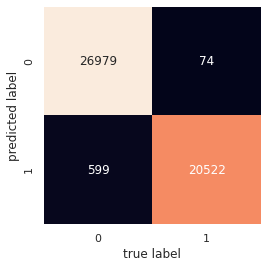

In [53]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_test_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Forecast skill reduction is preferentially due to rain wrongly predicted as snow.

Now let's look at some prediction scores, starting with R squared

In [46]:
#baseline train score for training data
print('Baseline score for training data = ', clf_1000.score(X_train, y_train))

#baseline test score for test data
print('Baseline score for test data = ', clf_1000.score(X_test, y_test))

Baseline score for training data =  0.9847781217750258
Baseline score for test data =  0.9860298086104538


Briar Score for training and testing

In [0]:
from sklearn.metrics import brier_score_loss
# Get probability of snow prediction
y_train_prob = clf_1000.predict_proba(X_train)[:,1]
# Get probability of snow prediction
y_test_prob = clf_1000.predict_proba(X_test)[:,1]

In [48]:
print('Brier score for training data = ', brier_score_loss(y_train,y_train_prob))
print('Brier score for test data = ', brier_score_loss(y_test,y_test_prob))

Brier score for training data =  0.013621863032887612
Brier score for test data =  0.013216536314770455


Briar Score for climatology

In [0]:
# This function generates a climatology probability array of desired shape for 1:Snow 
def get_clim_prob(y, shape): # Provide shape as a tuple (x1, x2)
  # calculate probability of 1.0 (snow)
  clim_1 = np.size((y > 0.).values.nonzero())/np.size(y)
  # create an array of same size as y
  clim_prob = np.zeros(shape)
  # Assign y as clim_1
  clim_prob[:] = clim_1
  return clim_prob

In [50]:
y_train_clim_prob = get_clim_prob(y_train, y_train.shape)
print('Brier score for climatology from training data = ', brier_score_loss(y_train,y_train_clim_prob))

y_test_clim_prob = get_clim_prob(y_test, y_test.shape)
print('Brier score for climatology from test data = ', brier_score_loss(y_test,y_test_clim_prob))

Brier score for climatology from training data =  0.24435135504805539
Brier score for climatology from test data =  0.24474860990073988


In [40]:
y_test_clim_prob

array([0.42753352, 0.42753352, 0.42753352, ..., 0.42753352, 0.42753352,
       0.42753352])

Briar Skill Score (compared to climatology) for Training and Validation datasets

In [51]:
bss_train = 1 - (brier_score_loss(y_train,y_train_prob)/brier_score_loss(y_train,y_train_clim_prob))
print('Brier skill score for training data = ', bss_train)

bss_test = 1 - (brier_score_loss(y_test,y_test_prob)/brier_score_loss(y_test,y_test_clim_prob))
print('Brier skill score for test data = ', bss_test)

Brier skill score for training data =  0.9442529670841864
Brier skill score for test data =  0.9459995449202733


Let's also look at the ROC curve for the forecast

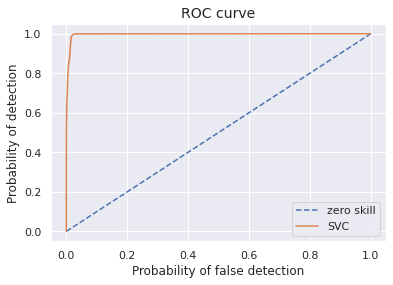

In [55]:
from sklearn.metrics import roc_curve
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--', label = 'zero skill')
# plot the roc curve for the model
plt.plot(fpr, tpr, label = 'SVC')
# title
plt.xlabel('Probability of false detection')
plt.ylabel('Probability of detection')
plt.title('ROC curve', fontsize = 14)
plt.legend(loc = 'best')
# show the plot
plt.show()